In [ ]:
!pip install torch torchvision torchaudio
!pip install lightning
!pip install kaggle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import torch
import torchvision
import lightning as L
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader,random_split,Subset, SubsetRandomSampler
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchsummary import summary
from tqdm import tqdm
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, Callback
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-know-what-you-did-last-measurement-time

# Unzip the downloaded files and then remove the zip files
!unzip bgu-i-know-what-you-did-last-measurement-time.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### **Preprocess & save to pickels**

In [ ]:
def process_and_save_type1_files(data_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through each file in the directory
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)

        try:
            data = pd.read_csv(file_path)

            # Check if it's a type 1 file
            if 'measurement type' in data.columns:
                # Filter for acceleration data
                filtered_data = data[data['measurement type'] == 'acceleration [m/s/s]']

                # Save as pickle
                output_file_path = os.path.join(output_dir, f"{filename.split('.')[0]}.pkl")
                filtered_data.to_pickle(output_file_path)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")


In [ ]:
data_dir = unlabeled_dir
output_dir = '/content/drive/My Drive/DLW_Dataset/filtered_data_type1'
process_and_save_type1_files(data_dir, output_dir)

In [ ]:
output_dir = '/content/drive/My Drive/DLW_Dataset/filtered_data_type1'

# List all files in the output directory
files_in_output_dir = os.listdir(output_dir)

# Print the number of files
print(f"Number of files in the output directory: {len(files_in_output_dir)}")

Number of files in the output directory: 88373


In [ ]:
import pickle

# Specify the file path
pickle_file_path = '/content/drive/My Drive/DLW_Dataset/filtered_data_type1/3.pkl'

# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

# Print the first 5 rows of the data
print(data.head())


        measurement type          x         y         z
0   acceleration [m/s/s]  -9.081471 -5.969739 -1.010116
3   acceleration [m/s/s]  -9.636795 -4.543129 -0.818625
6   acceleration [m/s/s] -10.450633 -2.130340 -0.253726
9   acceleration [m/s/s] -11.015532 -1.192033  0.119682
12  acceleration [m/s/s] -11.762347 -0.272875  0.627134


In [ ]:
def process_and_save_type2_files(data_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through each file in the data directory
    for filename in os.listdir(data_dir):
        if not filename.endswith('.csv'):
            continue  # Skip non-CSV files

        file_path = os.path.join(data_dir, filename)

        try:
            # Load the data
            data = pd.read_csv(file_path)

            # Check if it's a Type 2 file by checking for the absence of 'measurement type'
            if 'measurement type' not in data.columns:
                # Since it's a Type 2 file, save it directly without filtering
                output_file_path = os.path.join(output_dir, f"{filename.split('.')[0]}.pkl")
                data.to_pickle(output_file_path)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

In [ ]:
# Define your directories
data_dir = unlabeled_dir
output_dir_type2 = '/content/drive/My Drive/DLW_Dataset/filtered_data_type2'

# Process and save Type 2 files
process_and_save_type2_files(data_dir, output_dir_type2)

In [ ]:
output_dir_type2 = '/content/drive/My Drive/DLW_Dataset/filtered_data_type2'

# List all files in the output directory
files_in_output_dir_type2 = os.listdir(output_dir_type2)

# Print the number of files
print(f"Number of files in the output directory: {len(files_in_output_dir_type2)}")

Number of files in the output directory: 36619


In [ ]:
def process_unlabeled_files_with_paths(data_dir):
    type1_files_paths = {}
    type2_files_paths = {}

    # Iterate through each file in the directory
    for filename in os.listdir(data_dir):
        # Construct the full file path
        file_path = os.path.join(data_dir, filename)
        # Extract file id from filename (assuming filename format is "{id}.csv")
        file_id = filename.split('.')[0]

        # Read the file to determine its type
        try:
            data = pd.read_csv(file_path)
            # Determine the type of file based on the presence of 'measurement type' column
            if 'measurement type' in data.columns:
                # Add to type 1 files paths dictionary
                type1_files_paths[file_id] = file_path
            else:
                # Add to type 2 files paths dictionary
                type2_files_paths[file_id] = file_path
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

    # Return the dictionaries of file IDs and paths
    return type1_files_paths, type2_files_paths

# Assuming 'unlabeled_dir' is correctly set to your unlabeled folder path
unlabeled_dir = unlabeled_dir
type1_files_paths, type2_files_paths = process_unlabeled_files_with_paths(unlabeled_dir)

# Example: print the number of files of each type
print(f"Number of type 1 file paths: {len(type1_files_paths)}")
print(f"Number of type 2 file paths: {len(type2_files_paths)}")

Number of type 1 file paths: 88373
Number of type 2 file paths: 36619


In [ ]:
# Assuming 'train_data' is your DataFrame containing the dataset
sensor_counts = train_data['sensor'].value_counts()

print("Number of samples for each type of sensor:")
print(sensor_counts)


Number of samples for each type of sensor:
smartwatch    36186
vicon         14062
Name: sensor, dtype: int64


In [ ]:
def classify_file_ids_by_sensor(file_paths_dict, train_data):
    classified_ids = {'vicon': [], 'smartwatch': []}

    for file_id in file_paths_dict.keys():
        # Lookup sensor type for this ID in the train data
        sensor_type_query = train_data.loc[train_data['id'].astype(str) == file_id, 'sensor']
        if not sensor_type_query.empty:
            sensor_type = sensor_type_query.values[0]
            # Append file ID to the appropriate list based on sensor type
            if sensor_type in classified_ids:
                classified_ids[sensor_type].append(file_id)

    return classified_ids

In [ ]:
type1_classified_ids = classify_file_ids_by_sensor(type1_files_paths, train_data)

type2_classified_ids = classify_file_ids_by_sensor(type2_files_paths, train_data)

In [ ]:
print("Type 1 Files Classified by Sensor:")
print("Vicon:", len(type1_classified_ids['vicon']))
print("Smartwatch:", len(type1_classified_ids['smartwatch']))

print("\nType 2 Files Classified by Sensor:")
print("Vicon:", len(type2_classified_ids['vicon']))
print("Smartwatch:", len(type2_classified_ids['smartwatch']))

Type 1 Files Classified by Sensor:
Vicon: 0
Smartwatch: 36186

Type 2 Files Classified by Sensor:
Vicon: 14062
Smartwatch: 0


In [ ]:
import os
import pickle

def save_dict_to_pickle(dict_obj, filepath):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    with open(filepath, 'wb') as file:
        pickle.dump(dict_obj, file)
    print(f"Dictionary saved to {filepath}")

output_dir = '/content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor'

# Saving the classified IDs dictionaries
save_dict_to_pickle(type1_classified_ids, os.path.join(output_dir, 'type1_classified_ids.pkl'))
save_dict_to_pickle(type2_classified_ids, os.path.join(output_dir, 'type2_classified_ids.pkl'))

Dictionary saved to /content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/type1_classified_ids.pkl
Dictionary saved to /content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/type2_classified_ids.pkl


In [ ]:
# Define the paths to your saved pickle files
type1_classified_ids_path = '/content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/type1_classified_ids.pkl'
type2_classified_ids_path = '/content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/type2_classified_ids.pkl'

# Function to load a dictionary from a pickle file
def load_dict_from_pickle(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

# Load the dictionaries
type1_classified_ids = load_dict_from_pickle(type1_classified_ids_path)
type2_classified_ids = load_dict_from_pickle(type2_classified_ids_path)

# Check the dictionaries
print("Type 1 Classified IDs:")
print(type1_classified_ids)
print("\nType 2 Classified IDs:")
print(type2_classified_ids)

# Optionally, print the number of IDs in each category
print("\nNumber of Type 1 Vicon IDs:", len(type1_classified_ids.get('vicon', [])))
print("Number of Type 1 Smartwatch IDs:", len(type1_classified_ids.get('smartwatch', [])))
print("Number of Type 2 Vicon IDs:", len(type2_classified_ids.get('vicon', [])))
print("Number of Type 2 Smartwatch IDs:", len(type2_classified_ids.get('smartwatch', [])))

Type 1 Classified IDs:
{'vicon': [], 'smartwatch': ['50156', '26420', '21750', '628', '15819', '29657', '4947', '45949', '57771', '57379', '52976', '63591', '10464', '70586', '25010', '34761', '49171', '66057', '45076', '70019', '1503', '34896', '40635', '11191', '43139', '3654', '26393', '599', '74476', '21698', '47014', '25627', '40607', '20060', '50268', '33351', '15659', '5377', '49305', '65584', '49136', '69584', '47160', '8335', '69643', '76808', '32367', '49929', '52175', '4003', '29929', '19822', '24638', '23218', '11084', '45066', '38296', '28941', '72335', '73258', '29659', '68990', '59248', '5624', '5420', '39880', '33392', '29688', '5553', '30179', '12658', '24727', '7146', '20009', '61495', '36579', '40004', '10055', '50377', '74443', '44655', '13840', '73999', '3065', '29431', '2101', '18510', '31240', '31120', '8675', '75015', '17069', '18626', '19533', '1490', '16727', '61151', '15214', '71633', '24004', '40179', '17848', '9141', '39601', '43292', '3826', '37286', '2941

In [ ]:
output_dir = '/content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor'  # Adjust the path as necessary
for filename in os.listdir(output_dir):
    print(filename)

type1_classified_ids.pkl
type2_classified_ids.pkl
filtered_type1_smartwatch_ids.pkl
filtered_type2_vicon_ids.pkl


In [ ]:
# Assuming 'type1_classified_ids' and 'type2_classified_ids' are your existing dictionaries
filtered_type1_classified_ids = {'smartwatch': type1_classified_ids['smartwatch']}
filtered_type2_classified_ids = {'vicon': type2_classified_ids['vicon']}

# Specify the directory where you want to save the pickle files
output_dir = '/content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/'

# Function to save a dictionary as a pickle file
def save_dict_as_pickle(dict_obj, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(dict_obj, file)
    print(f'Saved: {file_path}')

# Save the filtered dictionaries
save_dict_as_pickle(filtered_type1_classified_ids, os.path.join(output_dir, 'filtered_type1_smartwatch_ids.pkl'))
save_dict_as_pickle(filtered_type2_classified_ids, os.path.join(output_dir, 'filtered_type2_vicon_ids.pkl'))


Saved: /content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/filtered_type1_smartwatch_ids.pkl
Saved: /content/drive/My Drive/DLW_Dataset/classify_ids_by_sensor/filtered_type2_vicon_ids.pkl


### **Load the Preprocessed & normalized**

In [ ]:
base_dir = '/content/drive/MyDrive/DLW_Dataset/classify_ids_by_sensor'
filtered_type1_smartwatch_path = os.path.join(base_dir, 'filtered_type1_smartwatch_ids.pkl')
filtered_type2_vicon_path = os.path.join(base_dir, 'filtered_type2_vicon_ids.pkl')

In [ ]:
# Function to load a dictionary from a pickle file
def load_dict_from_pickle(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

# Loading the dictionaries
filtered_type1_smartwatch_ids = load_dict_from_pickle(filtered_type1_smartwatch_path)
filtered_type2_vicon_ids = load_dict_from_pickle(filtered_type2_vicon_path)

print("Loaded Type 1 Smartwatch IDs:", filtered_type1_smartwatch_ids)
print("Loaded Type 2 Vicon IDs:", filtered_type2_vicon_ids)

Loaded Type 1 Smartwatch IDs: {'smartwatch': ['50156', '26420', '21750', '628', '15819', '29657', '4947', '45949', '57771', '57379', '52976', '63591', '10464', '70586', '25010', '34761', '49171', '66057', '45076', '70019', '1503', '34896', '40635', '11191', '43139', '3654', '26393', '599', '74476', '21698', '47014', '25627', '40607', '20060', '50268', '33351', '15659', '5377', '49305', '65584', '49136', '69584', '47160', '8335', '69643', '76808', '32367', '49929', '52175', '4003', '29929', '19822', '24638', '23218', '11084', '45066', '38296', '28941', '72335', '73258', '29659', '68990', '59248', '5624', '5420', '39880', '33392', '29688', '5553', '30179', '12658', '24727', '7146', '20009', '61495', '36579', '40004', '10055', '50377', '74443', '44655', '13840', '73999', '3065', '29431', '2101', '18510', '31240', '31120', '8675', '75015', '17069', '18626', '19533', '1490', '16727', '61151', '15214', '71633', '24004', '40179', '17848', '9141', '39601', '43292', '3826', '37286', '29413', '1

#### **Normalize & Extract Features**

In [ ]:
def normalize_data_frame(data):
    for column in ['x', 'y', 'z']:
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return data

In [ ]:
def load_and_normalize_file(file_id, input_dir):
    input_file_path = os.path.join(input_dir, f"{file_id}.pkl")
    try:
        with open(input_file_path, 'rb') as file:
            data = pickle.load(file)
            normalized_data = normalize_data_frame(data)
            return normalized_data
    except OSError as e:
        print(f"Error processing file {file_id}: {e}")
        return None

In [ ]:
def normalize_and_review_data(file_ids, input_dir):
    normalized_data_samples = []
    for file_id in tqdm(file_ids, desc="Normalizing data"):
        normalized_data = load_and_normalize_file(file_id, input_dir)
        if normalized_data is not None:
            # Here you could add code to inspect the normalized data
            # For example, print summary statistics or plot some of its values
            # print(f"Data for file_id {file_id} has been normalized.")
            normalized_data_samples.append((file_id, normalized_data))
    return normalized_data_samples

In [ ]:
input_dir_type1 = '/content/drive/My Drive/DLW_Dataset/filtered_data_type1'
# output_dir_type1_normalized = '/content/drive/My Drive/DLW_Dataset/filtered_data_type1_normalized'
normalize_and_review_data(filtered_type1_smartwatch_ids['smartwatch'], input_dir_type1)

In [ ]:
def normalize_data(data):
    normalized_data = (data - data.mean()) / data.std()
    return normalized_data

In [ ]:
def extract_features(data):
    features = {}
    features['mean_x'] = data['x'].mean()
    features['std_x'] = data['x'].std()
    features['mean_y'] = data['y'].mean()
    features['std_y'] = data['y'].std()
    features['mean_z'] = data['z'].mean()
    features['std_z'] = data['z'].std()
    # Add more features as needed
    return features

In [ ]:
def process_files(file_ids, data_dir):
    all_features = []
    for file_id in tqdm(file_ids, desc="Processing files"):
        file_path = os.path.join(data_dir, f"{file_id}.pkl")
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            # Normalize data
            data['x'] = normalize_data(data['x'])
            data['y'] = normalize_data(data['y'])
            data['z'] = normalize_data(data['z'])
            # Extract features
            features = extract_features(data)
            features['id'] = file_id
            all_features.append(features)
    return all_features

In [ ]:
# Load ID dictionaries
with open('/content/drive/MyDrive/DLW_Dataset/classify_ids_by_sensor/filtered_type1_smartwatch_ids.pkl', 'rb') as f:
    filtered_type1_smartwatch_ids = pickle.load(f)

with open('/content/drive/MyDrive/DLW_Dataset/classify_ids_by_sensor/filtered_type2_vicon_ids.pkl', 'rb') as f:
    filtered_type2_vicon_ids = pickle.load(f)

In [ ]:
# Process and extract features
smartwatch_features = process_files(filtered_type1_smartwatch_ids['smartwatch'], '/content/drive/My Drive/DLW_Dataset/filtered_data_type1')
vicon_features = process_files(filtered_type2_vicon_ids['vicon'], '/content/drive/My Drive/DLW_Dataset/filtered_data_type2')

Processing files:  15%|█▌        | 5554/36186 [59:59<5:39:36,  1.50it/s]

## **Part 1 - Data analysis**








In [4]:
unlabeled_dir = '/content/unlabeled/unlabeled'

unlabeled_files = os.listdir(unlabeled_dir)

In [5]:
chosen_file = '1000.csv'
file_path = os.path.join(unlabeled_dir, chosen_file)

unlabeled_data = pd.read_csv(file_path)

unlabeled_data.head()

,x [m],y [m],z [m]
0,0.248291,-0.539940,0.981346
1,0.251185,-0.546111,0.981167
2,0.253321,-0.551731,0.980899
3,0.255408,-0.558027,0.980578
4,0.257563,-0.563953,0.980564


In [6]:
train_data = pd.read_csv('train.csv')

sample_submission_data = pd.read_csv('sample_submission.csv')

In [7]:
train_data.head()

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000
4,4,user07,using_phone,vicon,hand,left,61641,4000


In [ ]:
sensor_counts = train_data['sensor'].value_counts()

print("Number of samples for each type of sensor:")
print(sensor_counts)


Number of samples for each type of sensor:
smartwatch    36186
vicon         14062
Name: sensor, dtype: int64


In [ ]:
body_part_counts = train_data['body_part'].value_counts()

print("Number of samples for each type of body_part:")
print(body_part_counts)

Number of samples for each type of body_part:
hand    43096
foot     7152
Name: body_part, dtype: int64


In [ ]:
# Get basic information about the dataset
print("\nDataset information:")
print(train_data.info())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50248 entries, 0 to 50247
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       50248 non-null  int64 
 1   userid           50248 non-null  object
 2   activity         50248 non-null  object
 3   sensor           50248 non-null  object
 4   body_part        50248 non-null  object
 5   side             50248 non-null  object
 6   id               50248 non-null  int64 
 7   sequence_length  50248 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 3.1+ MB
None


In [ ]:
# Determine the number of subjects in the dataset
num_subjects = train_data['userid'].nunique()
print(f"\nNumber of subjects in the dataset: {num_subjects}")


Number of subjects in the dataset: 8


In [ ]:
# Describe the dataset
print("\nSummary statistics:")
print(train_data.describe())


Summary statistics:
       Unnamed: 0            id  sequence_length
count  50248.0000  50248.000000     50248.000000
mean   25123.5000  38664.997313      3491.760866
std    14505.4925  22322.819331       407.933470
min        0.0000      0.000000      3000.000000
25%    12561.7500  19347.500000      3000.000000
50%    25123.5000  38727.500000      3500.000000
75%    37685.2500  57974.250000      4000.000000
max    50247.0000  77303.000000      4000.000000


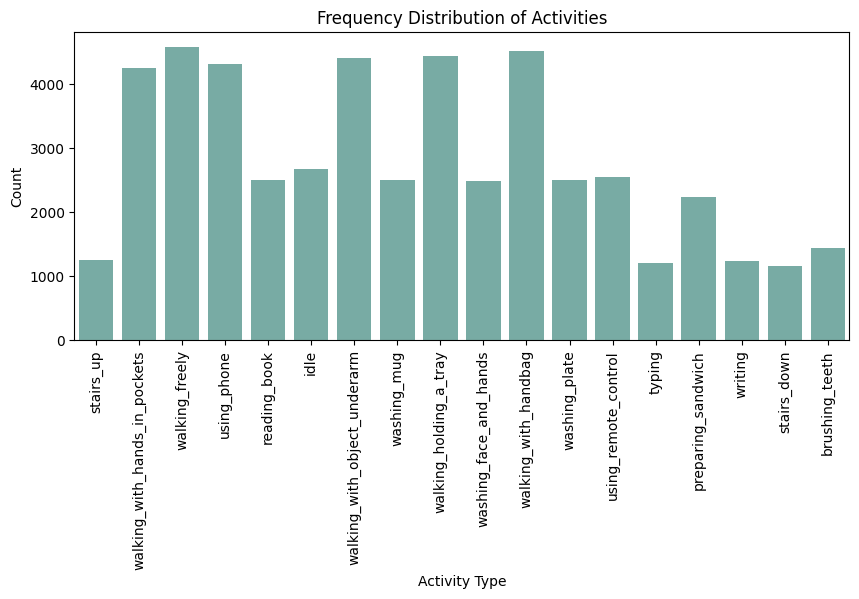

In [ ]:
# Assuming 'activity' is the column with activity labels
plt.figure(figsize=(10, 4))
# sns.countplot(x='activity', data=train_data, palette=sns.light_palette("lightblue", reverse=True))
sns.countplot(x='activity', data=train_data, color='#70b3aa')
#sns.countplot(x='activity', data=train_data, palette='coolwarm')
plt.title('Frequency Distribution of Activities')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.xlabel('Activity Type')
plt.show()

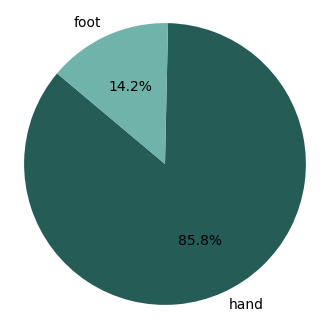

In [ ]:
# Calculate the percentage of samples for each body part
body_part_counts = train_data['body_part'].value_counts(normalize=True)

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(body_part_counts, labels=body_part_counts.index, autopct='%1.1f%%', startangle=140, colors=['#255c56','#70b3aa'])
# plt.title('Percentage of Samples by Body Part')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


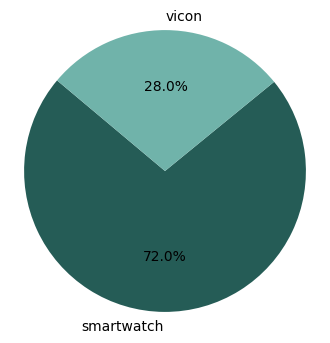

In [ ]:
# Calculate the percentage of samples for each Sensor
sensor_counts = train_data['sensor'].value_counts(normalize=True)

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(sensor_counts, labels=sensor_counts.index, autopct='%1.1f%%', startangle=140, colors=['#255c56','#70b3aa'])
# plt.title('Percentage of Samples by Body Part')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

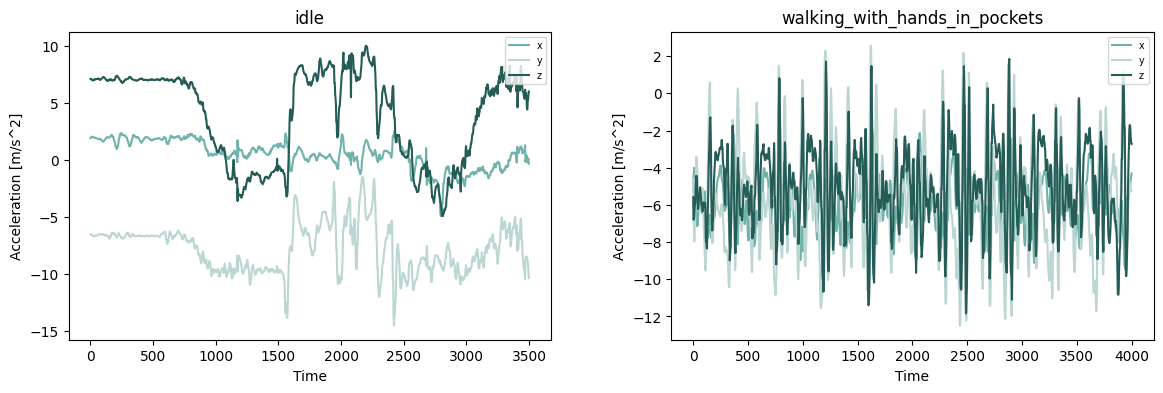

In [ ]:
# Examples of 2 different actions that are easy to distinguish

fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # One row, two columns
activities = ['idle', 'walking_with_hands_in_pockets']

for ax, activity in zip(axes, activities):
    # Find the first sequence ID for the current activity from train_data
    seq_id = train_data[train_data["activity"] == activity].iloc[0]['id']
    seq_file_path = os.path.join(unlabeled_dir, f'{seq_id}.csv')
    seq = pd.read_csv(seq_file_path)

    # Check and filter for acceleration data if necessary
    if "measurement type" in seq.columns:
        seq = seq[seq["measurement type"] == "acceleration [m/s/s]"]

    # Plotting
    seq.plot(ax=ax, title=activity, color=['#70b3aa','#bcd6d3','#255c56'])
    ax.legend(loc='upper right', fontsize='x-small')
    ax.set_xlabel('Time')
    ax.set_ylabel('Acceleration [m/s^2]')
    plt.subplots_adjust(wspace=0.25)

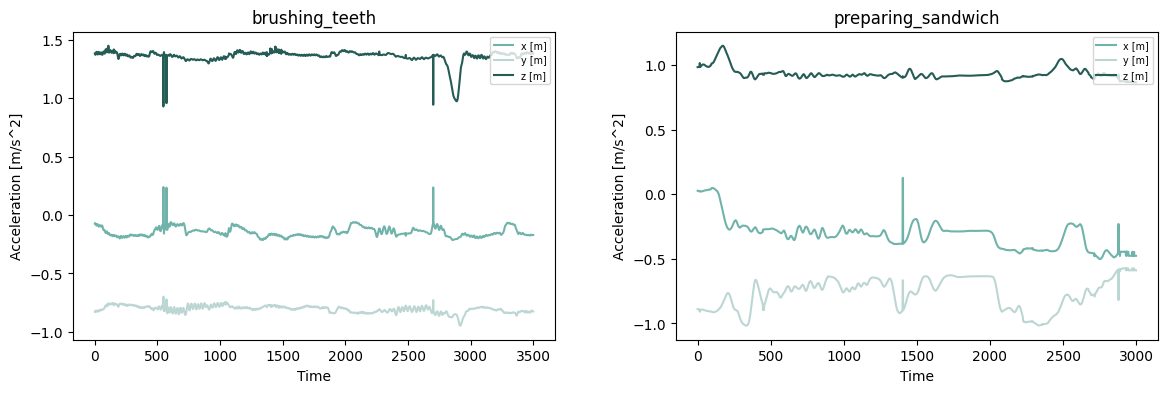

In [ ]:
# Examples of 2 different actions that are difficult to distinguish between them

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
activities = ['brushing_teeth', 'preparing_sandwich']

for ax, activity in zip(axes, activities):
    # Find the first sequence ID for the current activity from train_data
    seq_id = train_data[train_data["activity"] == activity].iloc[0]['id']
    seq_file_path = os.path.join(unlabeled_dir, f'{seq_id}.csv')
    seq = pd.read_csv(seq_file_path)

    # Check and filter for acceleration data if necessary
    if "measurement type" in seq.columns:
        seq = seq[seq["measurement type"] == "acceleration [m/s/s]"]

    # Plotting
    seq.plot(ax=ax, title=activity, color=['#70b3aa','#bcd6d3','#255c56'])
    ax.legend(loc='upper right', fontsize='x-small')
    ax.set_xlabel('Time')
    ax.set_ylabel('Acceleration [m/s^2]')
    plt.subplots_adjust(wspace=0.25)

In [8]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'activity' column to get encoded labels
train_data['activity_encoded'] = label_encoder.fit_transform(train_data['activity'])

In [9]:
train_data.head()

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length,activity_encoded
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000,5
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000,12
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000,12
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000,9
4,4,user07,using_phone,vicon,hand,left,61641,4000,7


In [10]:
# Create a copy of train_data
encoded_train_data = train_data.copy()

# One-hot encode categorical features on the copied DataFrame and drop the first to avoid multicollinearity
encoded_train_data = pd.get_dummies(encoded_train_data, columns=['sensor', 'body_part', 'side'], drop_first=True)

In [11]:
encoded_train_data.head()

,Unnamed: 0,userid,activity,id,sequence_length,activity_encoded,sensor_vicon,body_part_hand,side_right
0,0,user01,stairs_up,3387,3000,5,0,1,1
1,1,user01,walking_with_hands_in_pockets,8473,4000,12,0,1,0
2,2,user08,walking_with_hands_in_pockets,74365,3000,12,0,1,1
3,3,user01,walking_freely,6223,3000,9,0,1,1
4,4,user07,using_phone,61641,4000,7,1,1,0


## **Part 2 - Neural Network**

**a. validation strategy - train_test_split**

In [12]:
from sklearn.model_selection import train_test_split

# Identify unique users
unique_subjects = train_data['userid'].unique()

# Split user IDs into training and validation sets
train_subjects, val_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Create training and validation sets
train_set = train_data[train_data['userid'].isin(train_subjects)]
val_set = train_data[train_data['userid'].isin(val_subjects)]

# Summary of the split
print(f"Training set includes {len(train_set)} samples from {len(train_subjects)} subjects.")
print(f"Validation set includes {len(val_set)} samples from {len(val_subjects)} subjects.")

Training set includes 38001 samples from 6 subjects.
Validation set includes 12247 samples from 2 subjects.


**b. Naïve Baseline**

In [13]:
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

# Determine the most frequent class in the training set
most_common_class = Counter(train_set['activity_encoded']).most_common(1)[0][0]

# Predict this class for all instances in both sets
y_train_pred = [most_common_class] * len(train_set)
y_val_pred = [most_common_class] * len(val_set)

y_train_true = train_set['activity_encoded'].values
y_val_true = val_set['activity_encoded'].values

# Calculate accuracy for the training set & validation set
train_accuracy = accuracy_score(y_train_true, y_train_pred)
val_accuracy = accuracy_score(y_val_true, y_val_pred)

print(f"Naïve Baseline Train Accuracy: {train_accuracy:.4f}")
print(f"Naïve Baseline Validation Accuracy: {val_accuracy:.4f}")

Naïve Baseline Train Accuracy: 0.0900
Naïve Baseline Validation Accuracy: 0.0945


**c. Classical ML model**

In [14]:
import os
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_statistical_features(df, data_dir):
    """
    Extracts statistical features from time-series data corresponding to each row in the DataFrame.

    Parameters:
    - df: DataFrame with at least an 'id' column to locate the data files.
    - data_dir: The directory where the sequence data files are stored.

    Returns:
    - DataFrame with original data augmented with statistical features.
    """
    df = df.copy()

    means, stds, mins, maxs, medians, skews, kurtoses = [], [], [], [], [], [], []

    for _, row in df.iterrows():
        seq_id = row['id']
        file_path = os.path.join(data_dir, f"{seq_id}.csv")
        seq_df = pd.read_csv(file_path)

        # Filter by measurement type if necessary
        if "measurement type" in seq_df.columns:
            seq_df = seq_df[seq_df["measurement type"] == "acceleration [m/s/s]"]

        # Calculate statistical features for each axis
        for axis in ['x', 'y', 'z']:
            axis_data = seq_df[axis] if axis in seq_df.columns else seq_df[f"{axis} [m]"]
            means.append(axis_data.mean())
            stds.append(axis_data.std())
            mins.append(axis_data.min())
            maxs.append(axis_data.max())
            medians.append(axis_data.median())
            skews.append(skew(axis_data))  # Corrected
            kurtoses.append(kurtosis(axis_data))  # Corrected

    # Create a DataFrame with the calculated features
    features_df = pd.DataFrame({
        'x_mean': means[0::3], 'y_mean': means[1::3], 'z_mean': means[2::3],
        'x_std': stds[0::3], 'y_std': stds[1::3], 'z_std': stds[2::3],
        'x_min': mins[0::3], 'y_min': mins[1::3], 'z_min': mins[2::3],
        'x_max': maxs[0::3], 'y_max': maxs[1::3], 'z_max': maxs[2::3],
        'x_median': medians[0::3], 'y_median': medians[1::3], 'z_median': medians[2::3],
        'x_skew': skews[0::3], 'y_skew': skews[1::3], 'z_skew': skews[2::3],
        'x_kurtosis': kurtoses[0::3], 'y_kurtosis': kurtoses[1::3], 'z_kurtosis': kurtoses[2::3],
    })

    # Return the original DataFrame augmented with the new features
    return pd.concat([df.reset_index(drop=True), features_df], axis=1)

In [ ]:
train_features = extract_statistical_features(train_set, unlabeled_dir)
val_features = extract_statistical_features(val_set, unlabeled_dir)

In [ ]:
# Specify the paths where you want to save the CSV files
train_features_path = '/content/drive/My Drive/DLW_Dataset/train_features_2.csv'
val_features_path = '/content/drive/My Drive/DLW_Dataset/val_features_2.csv'

# Save the train_features DataFrame as a CSV file
train_features.to_csv(train_features_path, index=False)

# Save the val_features DataFrame as a CSV file
val_features.to_csv(val_features_path, index=False)

In [ ]:
# Create directory if it does not exist
os.makedirs(os.path.dirname(train_features_path), exist_ok=True)
os.makedirs(os.path.dirname(val_features_path), exist_ok=True)

In [16]:
# Load the train_features DataFrame from the saved CSV file
train_features_loaded = pd.read_csv('/content/train_features_1.csv')

# Load the val_features DataFrame from the saved CSV file
val_features_loaded = pd.read_csv('/content/val_features_1.csv')


In [17]:
features_columns = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std','x_min', 'y_min', 'z_min','x_max', 'y_max', 'z_max','x_median', 'y_median', 'z_median', 'x_skew', 'y_skew', 'z_skew','x_kurtosis', 'y_kurtosis', 'z_kurtosis']

In [18]:
# Assuming 'features_columns' is a list of your feature column names
X_train_loaded = train_features_loaded[features_columns].values
X_val_loaded = val_features_loaded[features_columns].values

y_train_loaded = train_features_loaded['activity_encoded'].values
y_val_loaded = val_features_loaded['activity_encoded'].values

**#Normlaize**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

In [ ]:
from sklearn.preprocessing import RobustScaler

def preprocess_data_R(data):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

In [ ]:
# X_train = preprocess_data_R(X_train_loaded)
# X_val = preprocess_data_R(X_val_loaded)

In [ ]:
# features_columns = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std','x_median', 'y_median', 'z_median', 'x_skew', 'y_skew', 'z_skew','x_kurtosis', 'y_kurtosis', 'z_kurtosis']

In [ ]:
# X_train = train_features[features_columns].values
# X_val = val_features[features_columns].values

# y_train = train_features['activity_encoded'].values
# y_val = val_features['activity_encoded'].values

**#RF**

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# Training the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=2, min_samples_leaf=12, bootstrap=False, n_jobs=-1 ,random_state=42)

# rf_clf.fit(X_train, y_train)
rf_clf.fit(X_train_loaded, y_train_loaded)

# Predicting on both training and validation sets
y_train_pred = rf_clf.predict(X_train_loaded)
y_val_pred = rf_clf.predict(X_val_loaded)

# # Calculating log loss for both training and validation sets
# train_log_loss = log_loss(y_train_loaded,y_train_pred)
# val_log_loss = log_loss(y_val_loaded, y_val_pred)

# Calculating and printing the accuracy for both training and validation sets
train_accuracy = accuracy_score(y_train_loaded, y_train_pred)
val_accuracy = accuracy_score(y_val_loaded, y_val_pred)

# Printing accuracy and log loss for both training and validation sets
print(f"Random Forest Training Accuracy: {train_accuracy:.4f}")
# print(f"Random Forest Training Log Loss: {train_log_loss:.4f}")
print(f"Random Forest Validation Accuracy: {val_accuracy:.4f}")
# print(f"Random Forest Validation Log Loss: {val_log_loss:.4f}")

Random Forest Training Accuracy: 0.9152
Random Forest Validation Accuracy: 0.4819


**#XGB**

In [21]:
import xgboost as xgb

# Initialize and train the XGBoost model
xgb_clf = xgb.XGBClassifier(n_estimators=100, objective='multi:softmax', num_class=18, max_depth=6, learning_rate=0.028, subsample=0.3 ,colsample_bytree=0.3, random_state=42)

# eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_clf.fit(X_train_loaded,  y_train_loaded)

# Predict and evaluate using the best iteration
y_train_pred = xgb_clf.predict(X_train_loaded)
y_val_pred = xgb_clf.predict(X_val_loaded)

train_accuracy = accuracy_score( y_train_loaded, y_train_pred)
val_accuracy = accuracy_score(y_val_loaded, y_val_pred)

print(f"XGB Training Accuracy: {train_accuracy:.4f}")
print(f"XGB Validation Accuracy: {val_accuracy:.4f}")

XGB Training Accuracy: 0.9000
XGB Validation Accuracy: 0.4926


## **Part 3 - Test Submission**

In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# # Extract sample_id
submission_ids = sample_submission['sample_id'].values

submission_ids_df = pd.DataFrame(submission_ids, columns=['id'])
# # Generate features for each sample_id
test_features = extract_statistical_features(submission_ids_df, unlabeled_dir)



In [ ]:
X_test = test_features[features_columns].values

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer instance
imputer = SimpleImputer(strategy='median')  # or use 'mean' depending on your preference

# But if you don't have X_train available, you can directly fit and transform on X_test
X_test_imputed = imputer.fit_transform(X_test)

# Now, X_test_imputed should not contain any NaNs, and you can use it with your classifier
predicted_probabilities = rf_clf.predict_proba(X_test_imputed)


In [ ]:
activities = list(sample_submission.columns[1:])  # Exclude 'sample_id'
activity_to_number_mapping = {activity: i for i, activity in enumerate(activities)}
number_to_activity_mapping = {i: activity for activity, i in activity_to_number_mapping.items()}

In [ ]:
preds_df = pd.DataFrame(predicted_probabilities, columns=[number_to_activity_mapping[i] for i in range(len(activities))])

In [ ]:
submission = pd.concat([pd.DataFrame(submission_ids, columns=['sample_id']), preds_df], axis=1)

In [ ]:
# Save the predictions to a CSV file
submission.to_csv('test_submission_rf.csv', index=False)